# Imports

In [2]:
import pyxdf
import pandas as pd
import numpy as np
from glob import glob
import datetime
import matplotlib.pyplot as plt
from pprint import pprint
import sys
import os
# Add the parent directory to the path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("utils"), '..')))
from utils import *
import math

# Load + Set Up

In [3]:
sub_files = glob('/Users/camilla.strauss/Desktop/CUNY_Data/Data/*/*.xdf')

In [4]:
sub_number = 8
xdf_path = sub_files[sub_number]
sub_id = xdf_path.split('/')[6].split('-')[1]

mic_df = import_mic_data(xdf_path)
stim_df = import_stim_data(xdf_path)
et_df = import_et_data(xdf_path)
cam_df = import_video_data(xdf_path)
eeg_df = import_eeg_data(xdf_path)
ps_df = import_physio_data(xdf_path)

In [5]:
et_df['diff'] = et_df.lsl_time_stamp.diff()

srate = 1/(et_df['diff'].median()) # example, for eye tracking 
srate

119.99574091501347

In [6]:
# find indexes of where diff is not as expected
loss_index = np.where(et_df['diff'] > 1/srate+.01)[0]
loss_index
# or np.where(et_df['diff'] > et_df['diff'].median()+.01)[0]

array([], dtype=int64)

## LSL start times

In [8]:
modalities = ['et', 'ps', 'mic', 'cam', 'eeg', 'stim']
stim_start = stim_df['lsl_time_stamp'][0]
mic_start = mic_df['lsl_time_stamp'][0]
cam_start = cam_df['lsl_time_stamp'][0]
ps_start = ps_df['lsl_time_stamp'][0]
eeg_start = eeg_df['lsl_time_stamp'][0]
et_start = et_df['lsl_time_stamp'][0]

lsl_start_df = pd.DataFrame(columns = ['modality', 'lsl_start'])
lsl_start_df['modality'] = modalities
lsl_start_df['lsl_start'] = [et_start, ps_start, mic_start, cam_start, eeg_start, stim_start]
lsl_start_df.sort_values(by = 'lsl_start', inplace = True)
lsl_start_df

,modality,lsl_start
1,ps,486656.526262
4,eeg,486656.660870
3,cam,486663.348627
5,stim,486663.454963
0,et,486663.718473
2,mic,487027.606832


In [9]:
# differences in start time (ie start times relative to the first one)
relative_starts = lsl_start_df.reset_index(drop = True)
first_start = relative_starts.loc[0]['lsl_start']
relative_starts['lsl_start'] = round(relative_starts['lsl_start'] - first_start, 4)
relative_starts

,modality,lsl_start
0,ps,0.0000
1,eeg,0.1346
2,cam,6.8224
3,stim,6.9287
4,et,7.1922
5,mic,371.0806


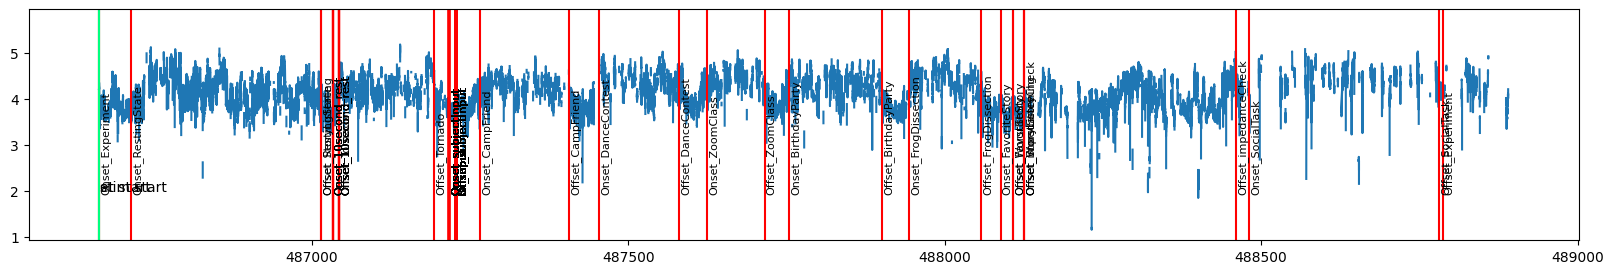

In [10]:
# plot stories, onset of stim and et, and loss if any
plt.figure(figsize = (20, 3))
plt.plot(et_df['lsl_time_stamp'], et_df['right_pupil_diameter'])
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']
for event1 in evs['event']:
    plt.axvline(stim_df.loc[stim_df.event == event1, 'lsl_time_stamp'].values[0], color='r')
    plt.text(stim_df.loc[stim_df.event == event1, 'lsl_time_stamp'].values[0]+2, 2, event1, rotation=90, fontsize = 8)

if loss_index.size > 0: 
    plt.axvline(et_df.loc[loss_index[0], 'lsl_time_stamp'], color='purple', linestyle = ':')
    plt.axvline(et_df.loc[loss_index[0]-1, 'lsl_time_stamp'], color='purple', linestyle = ':')


plt.axvline(stim_start, color = 'green')
plt.text(stim_start+1, 2, 'stim start')
plt.axvline(et_start, color = 'springgreen')
plt.text(et_start+1, 2, 'et start')

plt.show()

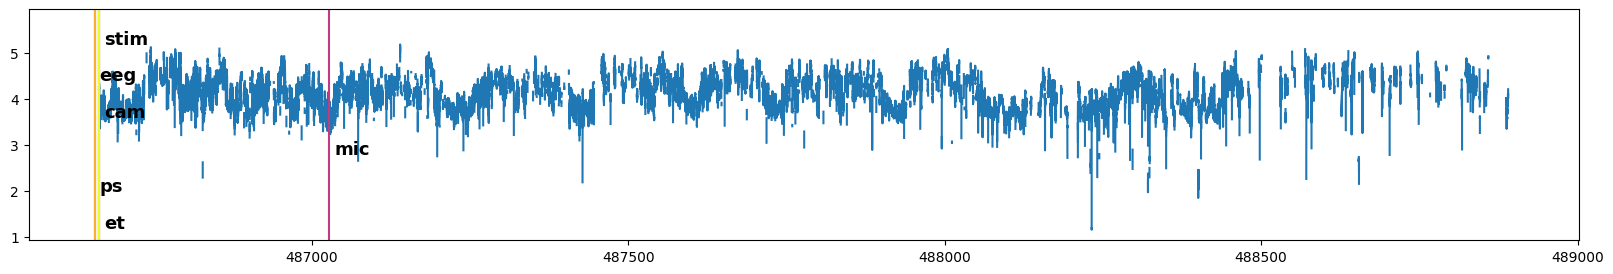

In [12]:
# plot start times
plt.figure(figsize=(20, 3))
plt.plot(et_df['lsl_time_stamp'], et_df['right_pupil_diameter'])

colors = plt.cm.plasma(np.linspace(.1, 1, len(modalities)))

i = 1.2
for color, modality in zip(colors, modalities):
    start = globals()[modality+'_start']
    plt.axvline(start, color = color)
    plt.text(start + 8, i, f'{modality}', fontsize = 13, fontweight = 'bold')
    i +=.8